Estudo de modelo de tendência usando o Holt-Winters

In [93]:
import pandas as pd
import pyodbc
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [94]:
def criar_conexao():
    dados_conexao = (
        "Driver={SQL Server};"
        "Server=SQLPW90DB03\DBINST3, 1443;"
        "Database=BDintelicanais;"
        "Trusted_Connection=yes;"
    )
    return pyodbc.connect(dados_conexao)

In [95]:
conexao = criar_conexao()

comando_sql = '''
SELECT CONVERT(DATE,[DT_REFERENCIA],103) AS DATA
	  ,[DS_PRODUTO]
      ,[DS_INDICADOR]
      ,[DS_UNIDADE_NEGOCIO]
      ,[NO_CURTO_TERRITORIO]
      ,[NO_MUNICIPIO]
      ,[DS_CANAL_BOV]
      ,sum(CAST([QTD] AS FLOAT)) as qtd
  FROM [BDintelicanais].[dbo].[TBL_CDO_FISICOS_REAL]
  where [DS_DET_INDICADOR] in ('NOVOS CLIENTES','MIG AQUISICAO')
        and [dt_anomes] >= '202301' 
        and [dt_anomes] <= '202308'
  group by [DS_PRODUTO]
      ,[DS_INDICADOR]
      ,CONVERT(DATE,[DT_REFERENCIA],103)
      ,[DS_UNIDADE_NEGOCIO]
      ,[NO_CURTO_TERRITORIO]
      ,[NO_MUNICIPIO]
      ,[DS_CANAL_BOV]
	  '''

df=pd.read_sql(comando_sql, conexao, parse_dates =['DATA'])
df.isnull().sum()

C:\Users\oi066724\AppData\Local\Temp\ipykernel_21080\3191224678.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(comando_sql, conexao, parse_dates =['DATA'])


DATA                   0
DS_PRODUTO             0
DS_INDICADOR           0
DS_UNIDADE_NEGOCIO     0
NO_CURTO_TERRITORIO    0
NO_MUNICIPIO           0
DS_CANAL_BOV           0
qtd                    0
dtype: int64

In [96]:
df.head()

,DATA,DS_PRODUTO,DS_INDICADOR,DS_UNIDADE_NEGOCIO,NO_CURTO_TERRITORIO,NO_MUNICIPIO,DS_CANAL_BOV,qtd
0,2023-01-02,FIBRA,GROSS,EMPRESARIAL,CE,FORTALEZA,AGENTES FIBRA,1.0
1,2023-01-02,FIBRA,GROSS,EMPRESARIAL,DF,BRASILIA,TLV ATIVO,1.0
2,2023-01-02,FIBRA,GROSS,EMPRESARIAL,DF,TAGUATINGA,TLV ATIVO,1.0
3,2023-01-02,FIBRA,GROSS,EMPRESARIAL,ES,CARIACICA,AGENTES FIBRA,6.0
4,2023-01-02,FIBRA,GROSS,EMPRESARIAL,ES,VILA VELHA,AGENTES FIBRA,2.0


In [97]:
df['qtd'] = df['qtd'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913505 entries, 0 to 913504
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATA                 913505 non-null  datetime64[ns]
 1   DS_PRODUTO           913505 non-null  object        
 2   DS_INDICADOR         913505 non-null  object        
 3   DS_UNIDADE_NEGOCIO   913505 non-null  object        
 4   NO_CURTO_TERRITORIO  913505 non-null  object        
 5   NO_MUNICIPIO         913505 non-null  object        
 6   DS_CANAL_BOV         913505 non-null  object        
 7   qtd                  913505 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 55.8+ MB


In [98]:
#FILTRAR APENAS A VL
df_vll=df.query('DS_INDICADOR == "VLL"')

#base apenas com DATA e valor
df_vll=df_vll[['DATA','qtd']]
df_vll.head()

,DATA,qtd
405111,2023-01-01,1.0
405112,2023-01-01,1.0
405113,2023-01-01,1.0
405114,2023-01-02,2.0
405115,2023-01-02,1.0


In [99]:
#Soma por DATA
df_a=df_vll.groupby('DATA').sum()
df_a.head()

,qtd
DATA,
2023-01-01,145.0
2023-01-02,5453.0
2023-01-03,6989.0
2023-01-04,6711.0
2023-01-05,7520.0


In [100]:
#diario 'D' > mensal 'MS'
df_b = df_a.resample(rule='D').sum()
df_b.head(10)

,qtd
DATA,
2023-01-01,145.0
2023-01-02,5453.0
2023-01-03,6989.0
2023-01-04,6711.0
2023-01-05,7520.0
2023-01-06,6502.0
2023-01-07,3178.0
2023-01-08,567.0
2023-01-09,7709.0


In [101]:
df_b.tail(10)

,qtd
DATA,
2023-08-15,1312.0
2023-08-16,6726.0
2023-08-17,7371.0
2023-08-18,5977.0
2023-08-19,3107.0
2023-08-20,650.0
2023-08-21,6842.0
2023-08-22,6576.0
2023-08-23,6567.0


<Axes: xlabel='DATA'>

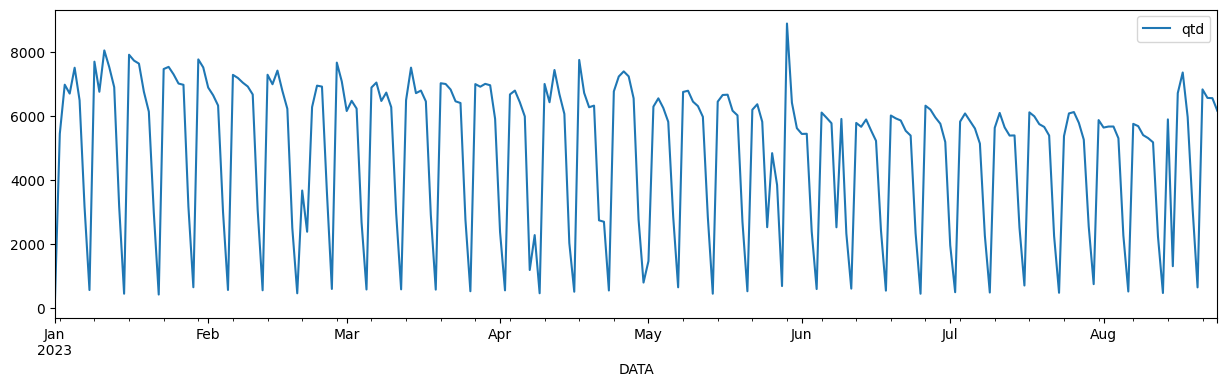

In [102]:
df_b.plot(figsize=(15,4))

In [103]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

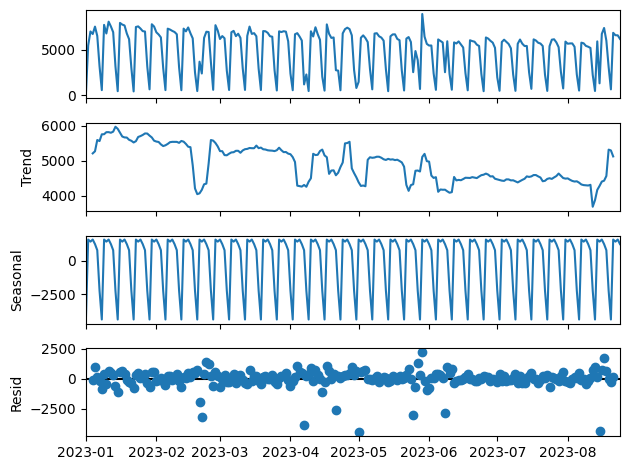

In [104]:
seasonal_decompose(df_b, model='additve', period=7).plot();

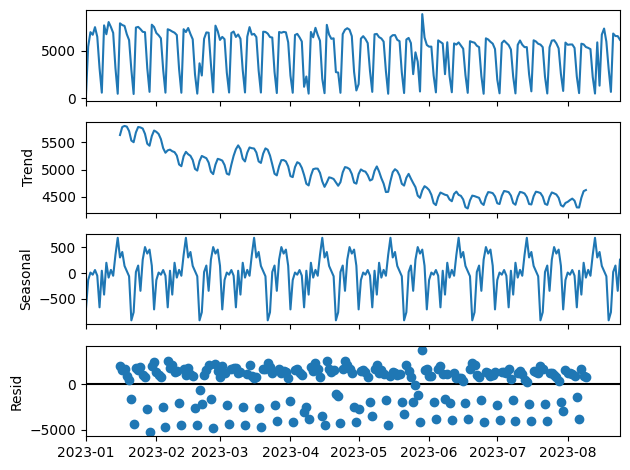

In [105]:
seasonal_decompose(df_b, model='additve', period=30).plot();

In [106]:

#localiza o INDICE de uma data expecifica para criar a base de TREINO e de TESTE
indice = df_b.index.get_loc('2023-08-01')
indice


212

In [107]:
#TRAIN and TEST
train = df_b[:indice]
test = df_b[indice:]


In [108]:
train.tail()

,qtd
DATA,
2023-07-27,5797.0
2023-07-28,5270.0
2023-07-29,2552.0
2023-07-30,751.0
2023-07-31,5882.0


In [109]:
test.head()

,qtd
DATA,
2023-08-01,5648.0
2023-08-02,5680.0
2023-08-03,5681.0
2023-08-04,5314.0
2023-08-05,2274.0


In [110]:
test.tail()

,qtd
DATA,
2023-08-20,650.0
2023-08-21,6842.0
2023-08-22,6576.0
2023-08-23,6567.0
2023-08-24,6173.0


In [121]:
hwmodel=ExponentialSmoothing(train.qtd, trend='additive', seasonal='additive', seasonal_periods=7).fit()

c:\Users\oi066724\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [122]:
test_pred=hwmodel.forecast(31)
test_pred

2023-08-01    6157.480378
2023-08-02    6040.529708
2023-08-03    5571.109027
2023-08-04    5364.341191
2023-08-05    2442.595848
2023-08-06     445.961379
2023-08-07    6069.745983
2023-08-08    6178.336998
2023-08-09    6061.386328
2023-08-10    5591.965647
2023-08-11    5385.197811
2023-08-12    2463.452468
2023-08-13     466.817998
2023-08-14    6090.602603
2023-08-15    6199.193617
2023-08-16    6082.242947
2023-08-17    5612.822266
2023-08-18    5406.054430
2023-08-19    2484.309087
2023-08-20     487.674618
2023-08-21    6111.459222
2023-08-22    6220.050237
2023-08-23    6103.099567
2023-08-24    5633.678886
2023-08-25    5426.911050
2023-08-26    2505.165707
2023-08-27     508.531237
2023-08-28    6132.315842
2023-08-29    6240.906857
2023-08-30    6123.956186
2023-08-31    5654.535505
Freq: D, dtype: float64

<Axes: xlabel='DATA'>

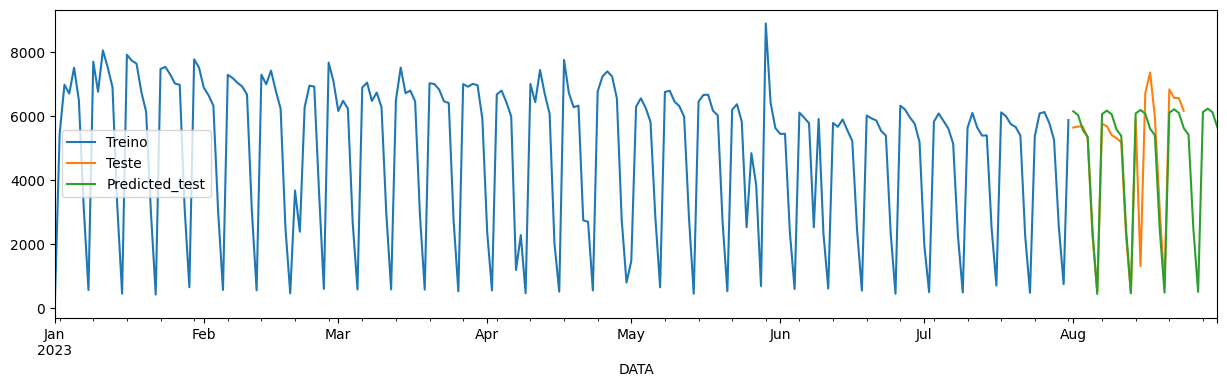

In [123]:
train['qtd'].plot(legend=True, label='Treino', figsize=(15,4))
test['qtd'].plot(legend=True, label='Teste')

test_pred.plot(legend=True, label='Predicted_test')

In [124]:
final_model=ExponentialSmoothing(df_b.qtd, trend='additive', seasonal='add', seasonal_periods=7).fit()

c:\Users\oi066724\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [125]:
pred=final_model.forecast(7)
pred

2023-08-25    5684.210021
2023-08-26    2760.045493
2023-08-27     763.535175
2023-08-28    6389.067868
2023-08-29    6009.432820
2023-08-30    6451.073228
2023-08-31    6139.834485
Freq: D, dtype: float64

<Axes: xlabel='DATA'>

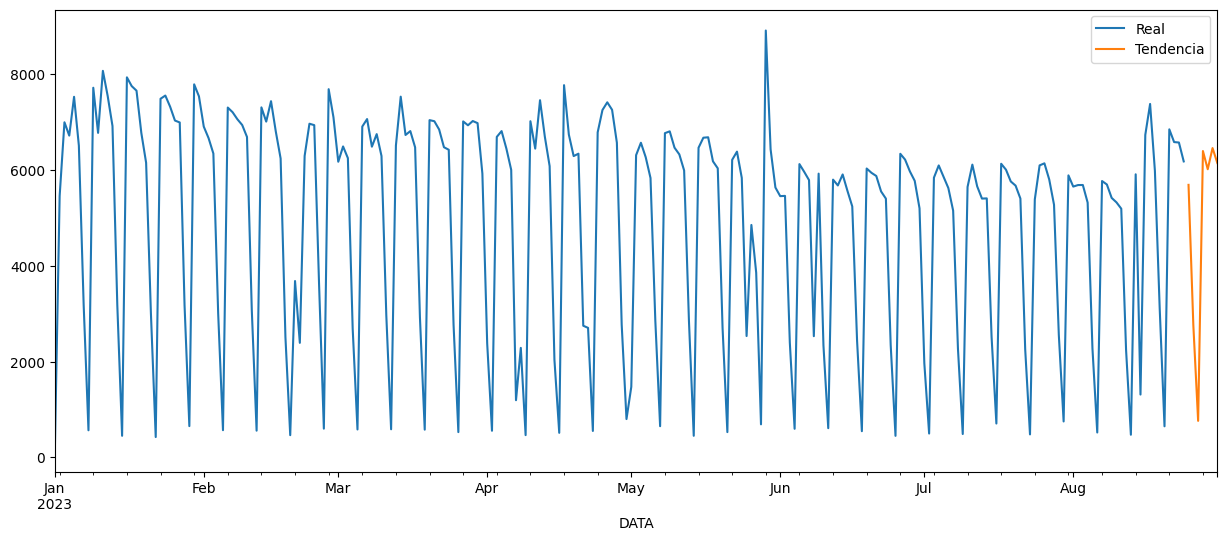

In [126]:
df_b['qtd'].plot(legend=True, label='Real', figsize=(15,6))
pred.plot(legend=True, label='Tendencia')